In [35]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

from sklearn.preprocessing import MinMaxScaler


import warnings
warnings.filterwarnings("ignore")

# read CSV file
df = pd.read_csv('gesture_feature_datasetSAGA.csv')

## Features and data (columns)

In [36]:
df.columns

Index(['Unnamed: 0', 'begintimes', 'endtimes', 'gesture_type', 'hand',
       'gesture_duration', 'gesturesid', 'ppn', 'sfeat_envaccpeaksd',
       'sfeat_envaccpeaks', 'sfeat_maxenvacc', 'sfeat_maxenvvel',
       'sfeat_maxenv', 'sfeat_meanf', 'sfeat_maxf0',
       'kfeat_wristindexdistanceright', 'kfeat_wristindexdistanceleft',
       'kfeat_thumbindexdistanceright', 'kfeat_thumbindexdistanceleft',
       'kfeat_wristwidthleftright', 'kfeat_wristheightright',
       'kfeat_wristheightleft', 'kfeat_timetospeedright',
       'kfeat_timetospeedleft', 'kfeat_avjerkright', 'kfeat_avjerkleft',
       'kfeat_peakswristright', 'kfeat_peakswristleft',
       'kfeat_maxspeedelbowright', 'kfeat_maxspeedelbowleft',
       'kfeat_maxaccwristleft', 'kfeat_maxspeedwristright',
       'kfeat_maxspeedwristleft'],
      dtype='object')

## Gesture types

In [37]:
df['gesture_type'].value_counts()

no_gesture             1338
iconic                  709
deictic                 203
iconic-deictic          109
discourse               104
move                    102
iconic-beat              55
beat                     30
deictic-beat             19
iconic-deictic-beat       6
discourse-iconic          6
discourse-beat            2
iconic                    1
Name: gesture_type, dtype: int64

## Mapping gestures types according to Wim's recommendations and binarizing them

In [38]:
df['gesture_type'] = df['gesture_type'].astype(str)
# in each row, remove empty spaces
df['gesture_type'] = df['gesture_type'].str.strip()
# Mapping dictionary
gesture_mapping = {
    "iconic": "representational",
    "deictic": "deictic",
    "iconic-deictic": "representational",
    "discourse": "representational",
    "move": "representational",
    "iconic-beat": "beat",
    "beat": "beat",
    "deictic-beat": "beat",
    "iconic-deictic-beat": "beat",
    "discourse-iconic": "representational",
    "discourse-beat": "beat",
    "no_gesture": "no_gesture"
}
df['generalized_gesture_type'] = df['gesture_type'].map(gesture_mapping)

# binarize the gesture type: 0 for no_gesture, 1 for gesture
df['binary_gesture_type'] = np.where(df['generalized_gesture_type']=='no_gesture', 'no_gesture', 'gesture')
display(df['generalized_gesture_type'].value_counts())
display(df['binary_gesture_type'].value_counts(normalize=True))



no_gesture          1338
representational    1031
deictic              203
beat                 112
Name: generalized_gesture_type, dtype: int64

gesture       0.50149
no_gesture    0.49851
Name: binary_gesture_type, dtype: float64

# Distribution of gestures

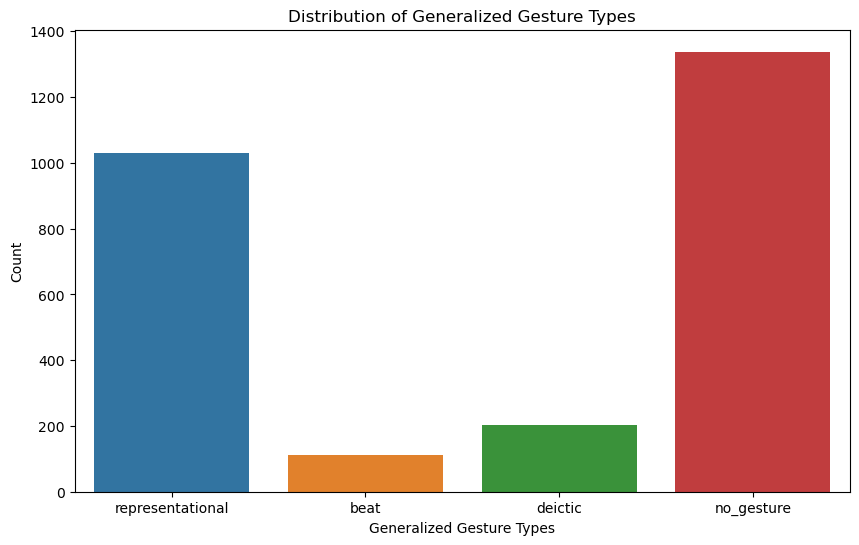

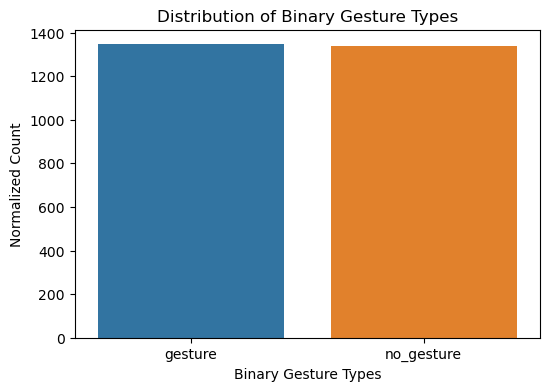

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming that df is your DataFrame

# Plotting the distribution of generalized_gesture_type
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='generalized_gesture_type')
plt.title('Distribution of Generalized Gesture Types')
plt.xlabel('Generalized Gesture Types')
plt.ylabel('Count')
plt.show()

# Plotting the distribution of binary_gesture_type
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='binary_gesture_type')
plt.title('Distribution of Binary Gesture Types')
plt.xlabel('Binary Gesture Types')
plt.ylabel('Normalized Count')
plt.show()


# Dimensionality reduction (t-SNE) and visualization

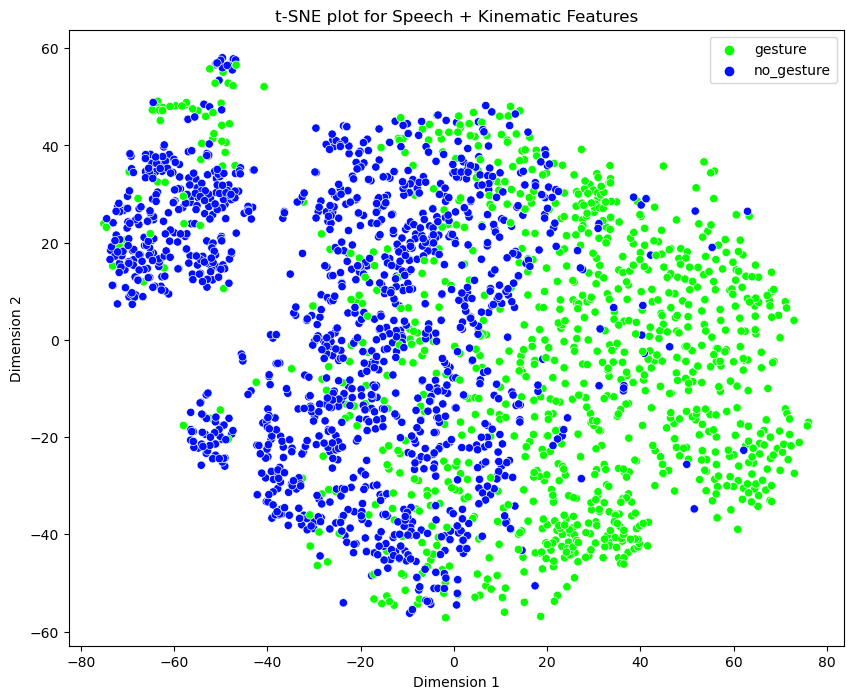

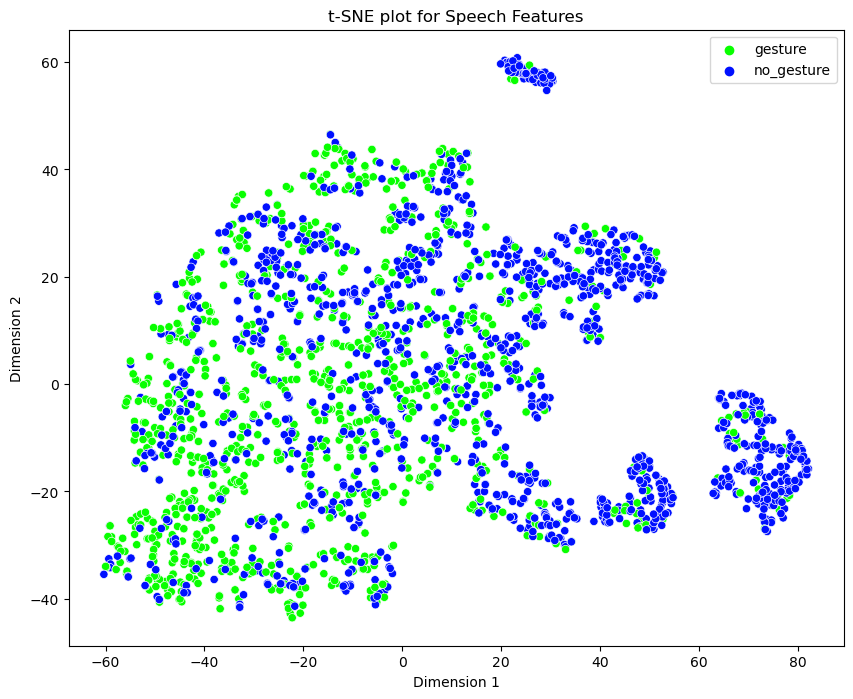

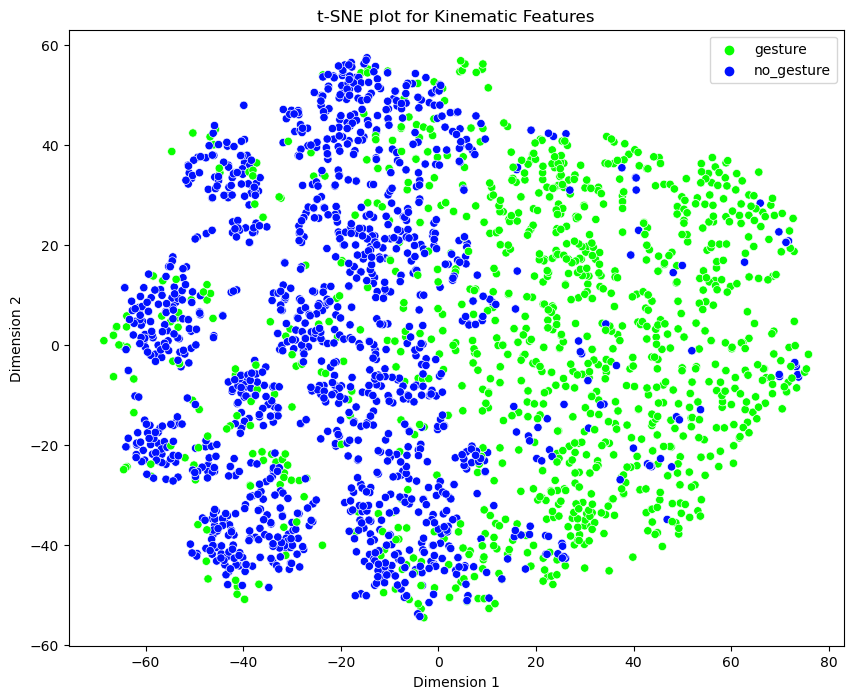

In [40]:
from sklearn.manifold import TSNE

def preprocess_data(X, y):
    # Replace NaN values with 0
    X = np.nan_to_num(X) 
    # Standardize the features
    sc = StandardScaler()
    X = sc.fit_transform(X)
    # Normalize features to lie in [-1, 1]
    mm_scaler = MinMaxScaler(feature_range=(-1, 1))
    X = mm_scaler.fit_transform(X)
    # Encode the labels
    le = LabelEncoder()
    y = le.fit_transform(y)
    return X, y

def plot_tsne(X, y, le, title):
    tsne = TSNE(n_components=2, random_state=0)
    X_2D = tsne.fit_transform(X)
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(X_2D[:, 0], X_2D[:, 1], hue=le.inverse_transform(y), legend="full", palette=sns.color_palette("hsv", len(np.unique(y))))
    
    plt.title(f't-SNE plot for {title} Features')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

X = df.iloc[:, 8:33].values
y = df.iloc[:, -1].values

le = LabelEncoder()
y = le.fit_transform(y)
X, _ = preprocess_data(X, y)

# Speech features
speech_features = df.iloc[:, 8:14].values
speech_features, _ = preprocess_data(speech_features, y)

# Kinematic features
kinematic_features = df.iloc[:, 14:33].values
kinematic_features, _ = preprocess_data(kinematic_features, y)

# Full model
plot_tsne(X, y, le, "Speech + Kinematic")

# Speech model
plot_tsne(speech_features, y, le, "Speech")

# Kinematic model
plot_tsne(kinematic_features, y, le, "Kinematic")


# Clustering with speakers as labels

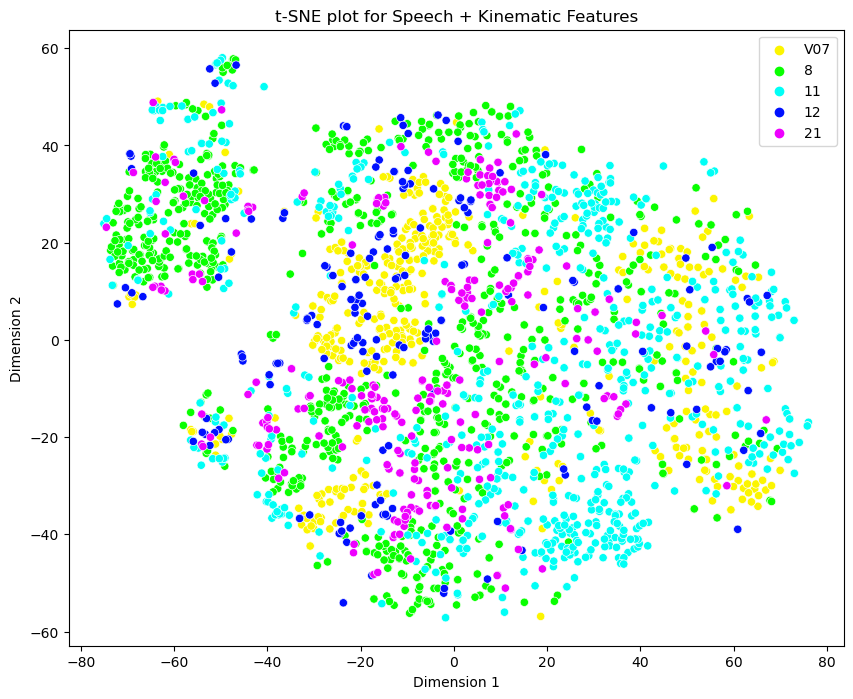

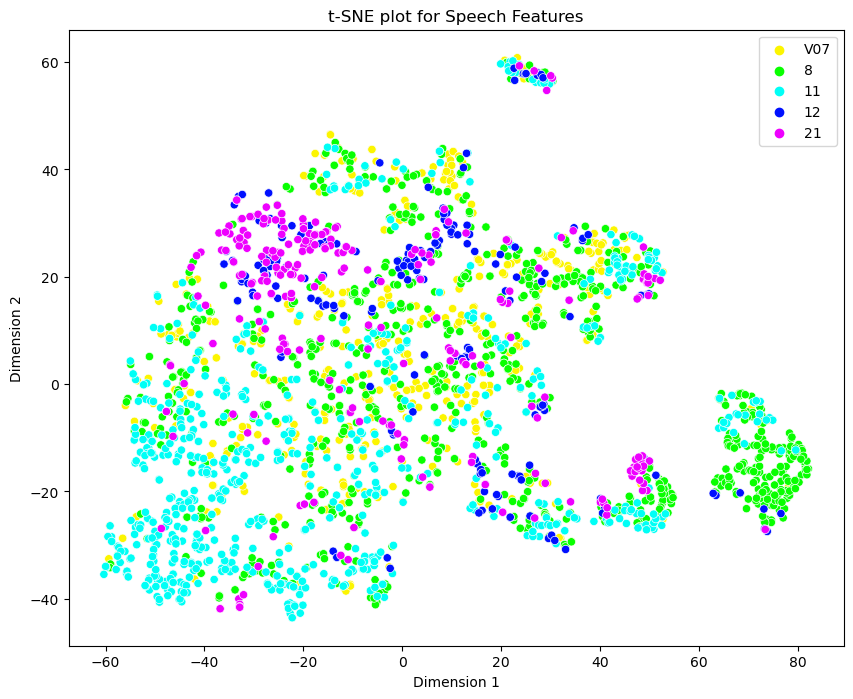

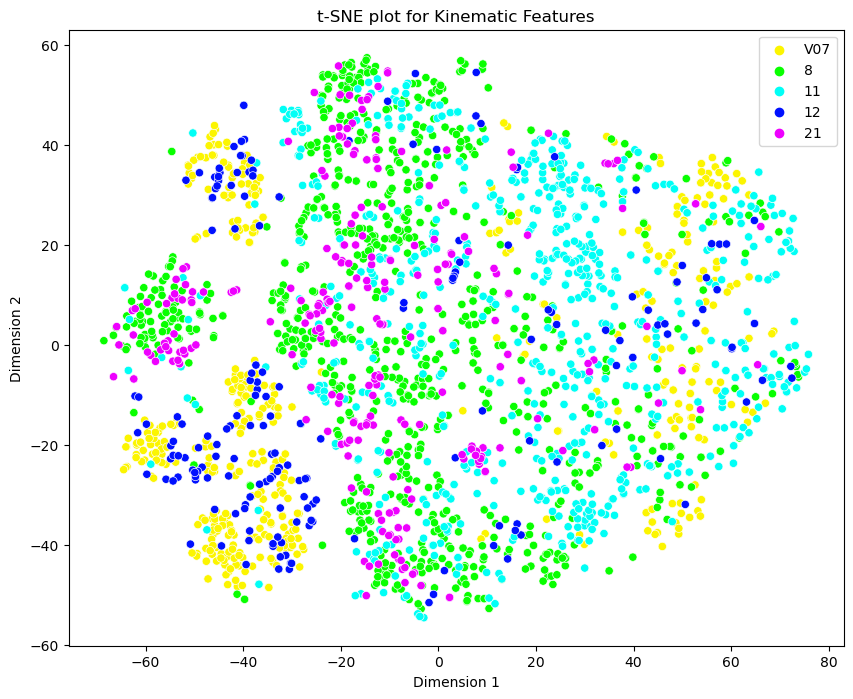

In [41]:
from sklearn.manifold import TSNE
def plot_tsne(X, y, le, title):
    tsne = TSNE(n_components=2, random_state=0)
    X_2D = tsne.fit_transform(X)
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(X_2D[:, 0], X_2D[:, 1], hue=le.inverse_transform(y), legend="full", palette=sns.color_palette("hsv", len(np.unique(y))))
    
    plt.title(f't-SNE plot for {title} Features')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

# Full model
le_speaker = LabelEncoder()
y_speaker = df['ppn']
y_speaker = le.fit_transform(y_speaker)
model = LogisticRegression()
plot_tsne(X, y_speaker, le, "Speech + Kinematic")

# Speech model
plot_tsne(speech_features, y_speaker, le, "Speech")

# Kinematic model
plot_tsne(kinematic_features, y_speaker, le, "Kinematic")


## A simple logistic regression model on speech, kinematics, and both data types combined


Speech + Kinematic Features
Accuracy on training set: 0.8604073522106309
Accuracy on test set: 0.8882265275707899
Confusion Matrix
[[284  53]
 [ 22 312]]


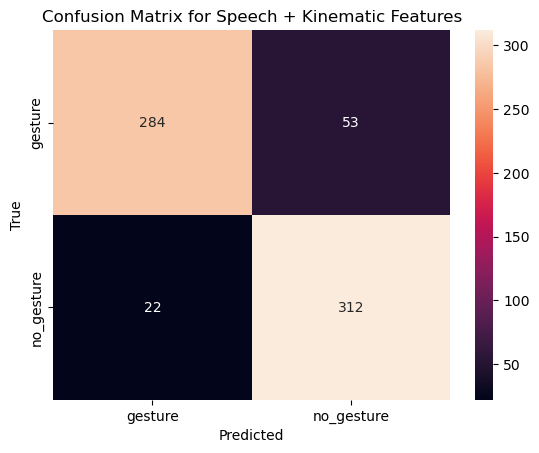

Classification Report
              precision    recall  f1-score   support

     gesture       0.93      0.84      0.88       337
  no_gesture       0.85      0.93      0.89       334

    accuracy                           0.89       671
   macro avg       0.89      0.89      0.89       671
weighted avg       0.89      0.89      0.89       671


Speech Features
Accuracy on training set: 0.6979632389468455
Accuracy on test set: 0.7257824143070045
Confusion Matrix
[[263  74]
 [110 224]]


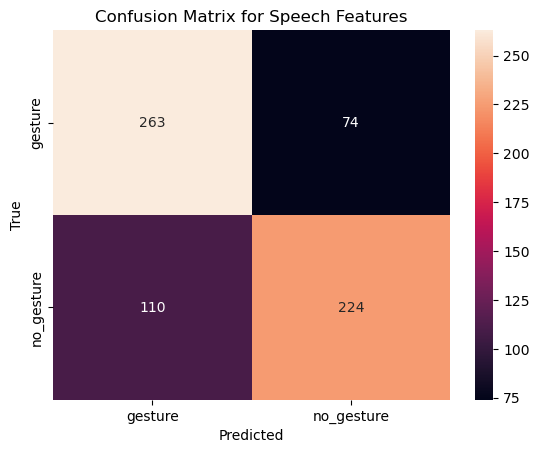

Classification Report
              precision    recall  f1-score   support

     gesture       0.71      0.78      0.74       337
  no_gesture       0.75      0.67      0.71       334

    accuracy                           0.73       671
   macro avg       0.73      0.73      0.72       671
weighted avg       0.73      0.73      0.72       671


Kinematic Features
Accuracy on training set: 0.8464977645305514
Accuracy on test set: 0.8643815201192251
Confusion Matrix
[[275  62]
 [ 29 305]]


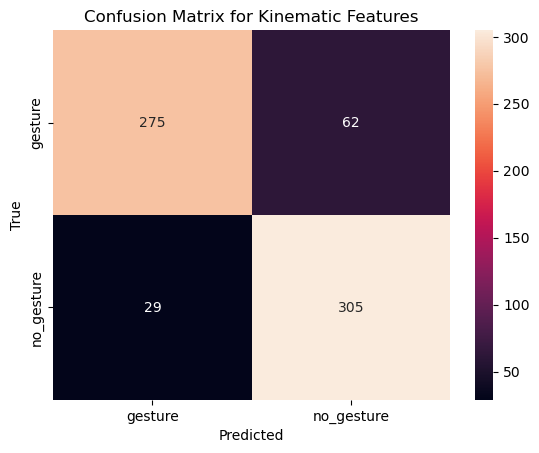

Classification Report
              precision    recall  f1-score   support

     gesture       0.90      0.82      0.86       337
  no_gesture       0.83      0.91      0.87       334

    accuracy                           0.86       671
   macro avg       0.87      0.86      0.86       671
weighted avg       0.87      0.86      0.86       671



In [42]:


def evaluate_and_plot(model, X, y, le, feature_type):
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)
    model.fit(X_train, y_train)
    
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    print(f"\n{feature_type} Features")
    print(f"Accuracy on training set: {train_score}")
    print(f"Accuracy on test set: {test_score}")
    
    y_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix")
    print(conf_matrix)
    
    gesture_names = le.inverse_transform(np.unique(y_test))
    
    sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=gesture_names, yticklabels=gesture_names)
    plt.title(f'Confusion Matrix for {feature_type} Features')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    print("Classification Report")
    print(classification_report(y_test, y_pred, target_names=gesture_names))


X = df.iloc[:, 8:33].values
y = df.iloc[:, -1].values

le = LabelEncoder()
y = le.fit_transform(y)
X, _ = preprocess_data(X, y)

# Speech features
speech_features = df.iloc[:, 8:14].values
speech_features, _ = preprocess_data(speech_features, y)

# Kinematic features
kinematic_features = df.iloc[:, 14:33].values
kinematic_features, _ = preprocess_data(kinematic_features, y)

# Full model
model = LogisticRegression()
evaluate_and_plot(model, X, y, le, "Speech + Kinematic")

# Speech model
evaluate_and_plot(model, speech_features, y, le, "Speech")

# Kinematic model
evaluate_and_plot(model, kinematic_features, y, le, "Kinematic")


## 3 layer NN model

In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X, y = preprocess_data(X, y)  

# Convert to PyTorch tensors
X_tensor = torch.FloatTensor(X)
y_tensor = torch.LongTensor(y) 

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Create DataLoader for training and testing data
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(dataset=train_data, batch_size=32, shuffle=True)

test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(dataset=test_data, batch_size=32)

# Define the Neural Network model
class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.layer1 = nn.Linear(input_dim, 64)
        self.layer2 = nn.Linear(64, 28)
        self.layer3 = nn.Linear(28, output_dim)
        self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.layer2(x)
        x = self.dropout(x)
        x = self.layer3(x)
        return x

# Initialize the model, loss and optimizer
input_dim = X_train.shape[1]
output_dim = len(torch.unique(y_train))
model = SimpleNN(input_dim, output_dim)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 40
for epoch in range(epochs):
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

# Evaluation
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

print(f"Accuracy: {(100 * correct / total):.2f}%")




Epoch [1/40], Loss: 0.8341
Epoch [2/40], Loss: 0.2296
Epoch [3/40], Loss: 0.1113
Epoch [4/40], Loss: 0.3251
Epoch [5/40], Loss: 1.4123
Epoch [6/40], Loss: 0.0334
Epoch [7/40], Loss: 0.1680
Epoch [8/40], Loss: 0.1380
Epoch [9/40], Loss: 0.0291
Epoch [10/40], Loss: 0.0921
Epoch [11/40], Loss: 0.2177
Epoch [12/40], Loss: 0.1055
Epoch [13/40], Loss: 1.2565
Epoch [14/40], Loss: 0.1311
Epoch [15/40], Loss: 0.2304
Epoch [16/40], Loss: 0.5121
Epoch [17/40], Loss: 0.1265
Epoch [18/40], Loss: 0.4617
Epoch [19/40], Loss: 0.1312
Epoch [20/40], Loss: 1.2146
Epoch [21/40], Loss: 0.2676
Epoch [22/40], Loss: 0.2486
Epoch [23/40], Loss: 0.0314
Epoch [24/40], Loss: 0.1869
Epoch [25/40], Loss: 0.0723
Epoch [26/40], Loss: 0.2755
Epoch [27/40], Loss: 0.0850
Epoch [28/40], Loss: 0.0397
Epoch [29/40], Loss: 0.0800
Epoch [30/40], Loss: 0.4364
Epoch [31/40], Loss: 0.0381
Epoch [32/40], Loss: 0.0083
Epoch [33/40], Loss: 0.0724
Epoch [34/40], Loss: 0.0209
Epoch [35/40], Loss: 0.1303
Epoch [36/40], Loss: 0.0668
E


Speech + Kinematic Features
Accuracy on training set: 0.8604073522106309
Accuracy on test set: 0.8882265275707899
Confusion Matrix
[[284  53]
 [ 22 312]]


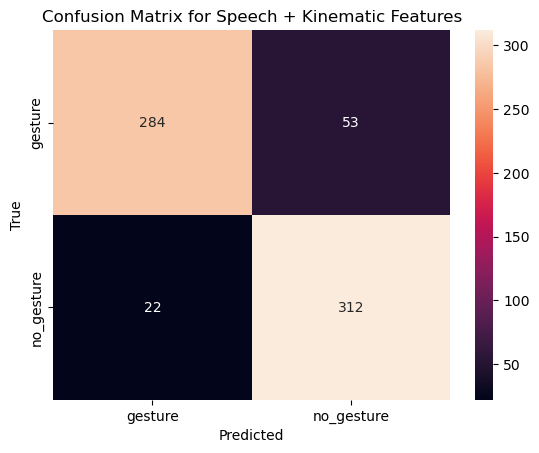

Classification Report
              precision    recall  f1-score   support

     gesture       0.93      0.84      0.88       337
  no_gesture       0.85      0.93      0.89       334

    accuracy                           0.89       671
   macro avg       0.89      0.89      0.89       671
weighted avg       0.89      0.89      0.89       671



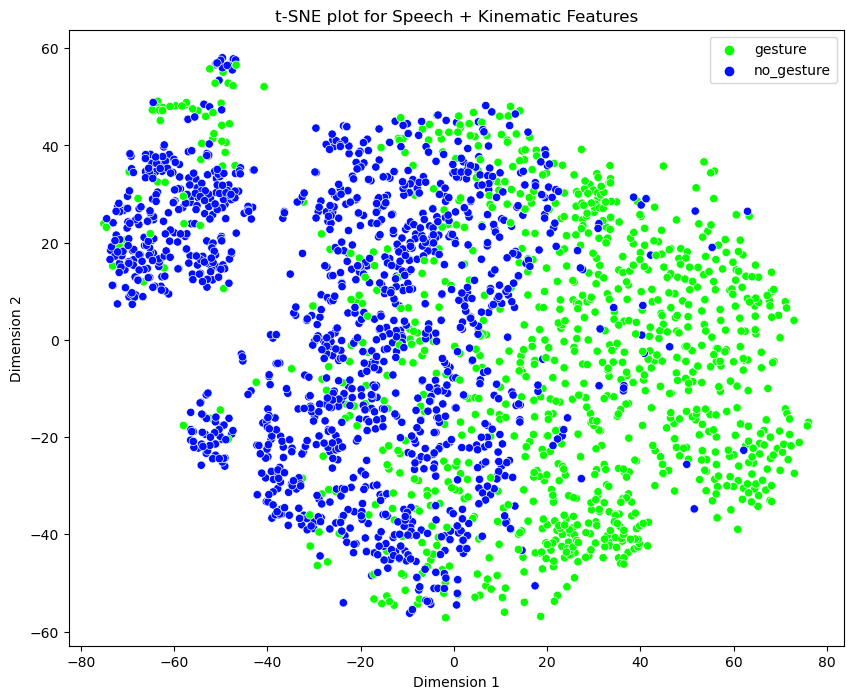


Speech Features
Accuracy on training set: 0.6979632389468455
Accuracy on test set: 0.7257824143070045
Confusion Matrix
[[263  74]
 [110 224]]


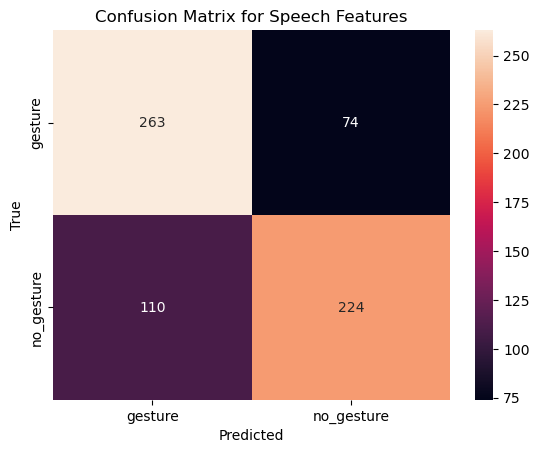

Classification Report
              precision    recall  f1-score   support

     gesture       0.71      0.78      0.74       337
  no_gesture       0.75      0.67      0.71       334

    accuracy                           0.73       671
   macro avg       0.73      0.73      0.72       671
weighted avg       0.73      0.73      0.72       671



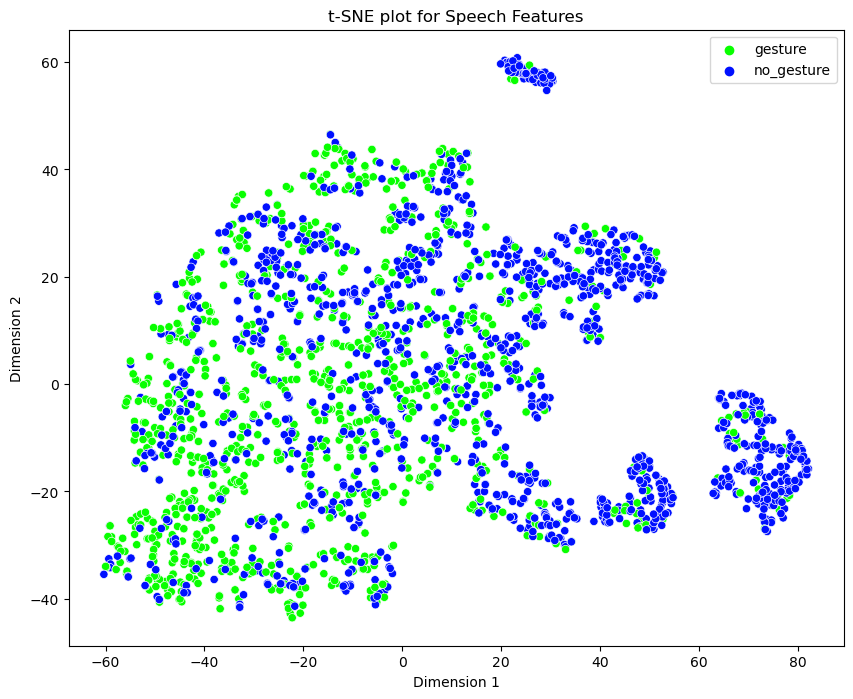


Kinematic Features
Accuracy on training set: 0.8464977645305514
Accuracy on test set: 0.8643815201192251
Confusion Matrix
[[275  62]
 [ 29 305]]


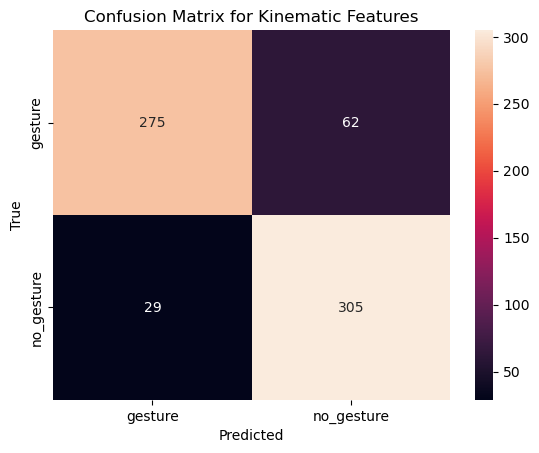

Classification Report
              precision    recall  f1-score   support

     gesture       0.90      0.82      0.86       337
  no_gesture       0.83      0.91      0.87       334

    accuracy                           0.86       671
   macro avg       0.87      0.86      0.86       671
weighted avg       0.87      0.86      0.86       671



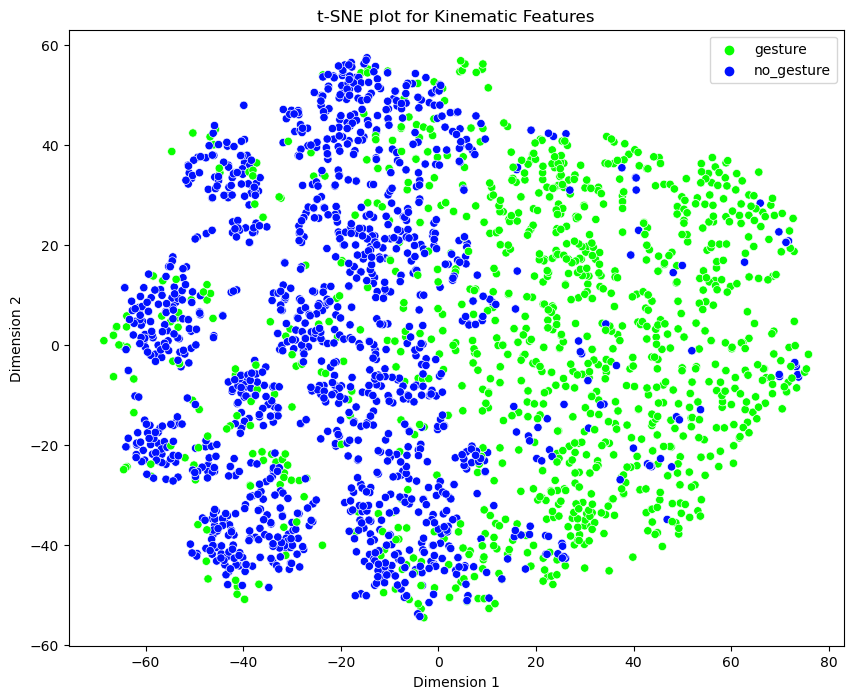

In [44]:
from sklearn.manifold import TSNE
def plot_tsne(X, y, le, title):
    tsne = TSNE(n_components=2, random_state=0)
    X_2D = tsne.fit_transform(X)
    
    plt.figure(figsize=(10, 8))
    sns.scatterplot(X_2D[:, 0], X_2D[:, 1], hue=le.inverse_transform(y), legend="full", palette=sns.color_palette("hsv", len(np.unique(y))))
    
    plt.title(f't-SNE plot for {title} Features')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

# Full model
model = LogisticRegression()
evaluate_and_plot(model, X, y, le, "Speech + Kinematic")
plot_tsne(X, y, le, "Speech + Kinematic")

# Speech model
evaluate_and_plot(model, speech_features, y, le, "Speech")
plot_tsne(speech_features, y, le, "Speech")

# Kinematic model
evaluate_and_plot(model, kinematic_features, y, le, "Kinematic")
plot_tsne(kinematic_features, y, le, "Kinematic")
